In [1]:
# load 
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
data_path = "processing/AITEX_cleaned_02.csv"
data_path = "processing/AITEX_clustering.csv"
data_path = "processing/AITEX_cluster_by_hand.csv"

df = pd.read_csv(data_path, sep=';')



In [3]:
# categorize Clustering
df['Cluster'] = df['Cluster'].astype('category')

array([[<AxesSubplot:title={'center':'Nº holes / Nº filaments'}>,
        <AxesSubplot:title={'center':'Diameter (mm)'}>,
        <AxesSubplot:title={'center':'L/D'}>,
        <AxesSubplot:title={'center':'Filter (um)'}>,
        <AxesSubplot:title={'center':'Sand quantity (cm)'}>],
       [<AxesSubplot:title={'center':'Support'}>,
        <AxesSubplot:title={'center':'Vpump (rpm)'}>,
        <AxesSubplot:title={'center':'Vext (rpm)'}>,
        <AxesSubplot:title={'center':'TE1 (°C)'}>,
        <AxesSubplot:title={'center':'TE2 (°C)'}>],
       [<AxesSubplot:title={'center':'TD(°C)'}>,
        <AxesSubplot:title={'center':'PD(bar)'}>,
        <AxesSubplot:title={'center':'PE(bar)'}>,
        <AxesSubplot:title={'center':'VTO (m/min)'}>,
        <AxesSubplot:title={'center':'VG1(m/min)'}>],
       [<AxesSubplot:title={'center':'VG2(m/min)'}>,
        <AxesSubplot:title={'center':'Vwinder (m/min)'}>,
        <AxesSubplot:title={'center':'Winder tension (N)'}>,
        <AxesSubplot:title=

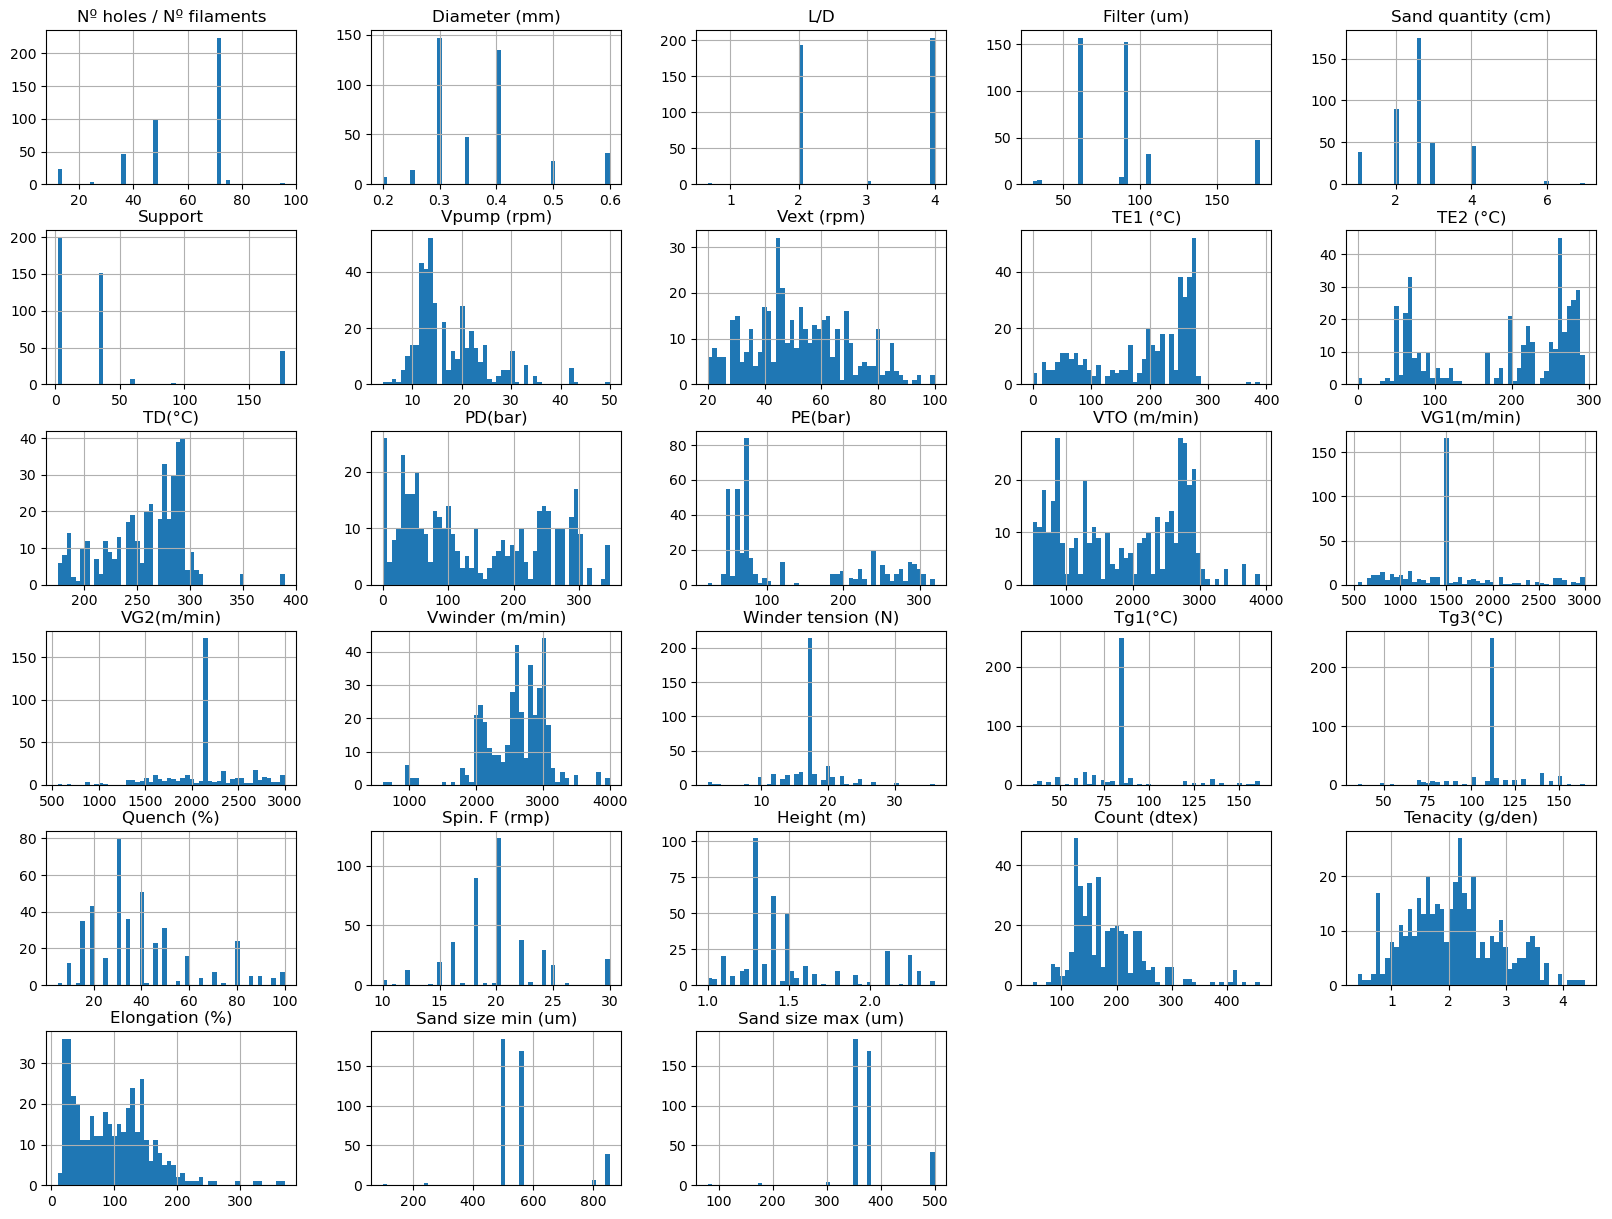

In [4]:
# hist 
df.hist(bins=50, figsize=(20,15))

In [5]:
# remove elongation > 250
df = df[df["Elongation (%)"] < 225]
# Count (dtex)
df = df[df["Count (dtex)"] < 300]

In [6]:
material_uq = df["Material"].value_counts()
material_uq = material_uq[material_uq > 10].index.tolist()

# remove the materials with less than 10 samples
# df = df[df.groupby('Material').Material.transform('count') > 10]

# if the material is not in the list, then it is "other"

df["Material"] = df["Material"].apply(lambda x: x if x in material_uq else "other")

In [7]:
df["Material"].value_counts()

other            303
rPET              24
PHB DAN 04493     20
TPX               16
TPX DX350         12
Name: Material, dtype: int64

In [8]:
df.pop("Material")

0      other
1      other
2      other
3      other
4      other
       ...  
399    other
400    other
401    other
402    other
403    other
Name: Material, Length: 375, dtype: object

In [9]:
# Material
df = pd.get_dummies(df, columns=['Cluster'], prefix='Cluster')

In [10]:

outputs_list = ["Tenacity (g/den)"]
remove = ["Count (dtex)","Elongation (%)"]
inputs_list = set(df.columns) - set(outputs_list) - set(remove)
inputs_list = list(inputs_list)

df = df[inputs_list + outputs_list]

In [11]:
inputs_full  = df[inputs_list]
outputs_full = df[outputs_list]

# test 0.2
from sklearn.model_selection import train_test_split

inputs, inputs_test, outputs, outputs_test = train_test_split(inputs_full, outputs_full, test_size=0.2)

In [12]:
# normalize 
in_mu = inputs.mean()
in_std = inputs.std()

out_mu = outputs.mean()
out_std = outputs.std()

in_norm = (inputs - in_mu) / in_std
out_norm = (outputs - out_mu) / out_std

In [13]:
import torch 

# convert to tensor
in_norm = torch.tensor(in_norm.values, dtype=torch.float32)
out_norm = torch.tensor(out_norm.values, dtype=torch.float32)

In [14]:
class Net(torch.nn.Module):
    def __init__(self,hidden_size=50):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(in_norm.shape[1], in_norm.shape[1])
        self.fc2 = torch.nn.Linear(in_norm.shape[1], hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
  
    def compute_l1_loss(self, w):
        return torch.abs(w).sum()
    
    def compute_l2_loss(self, w):
        return torch.pow(w, 2).sum()
    

net = Net()

In [15]:
import torch

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

batch_size = 128  # Tamaño de lote aleatorio
num_samples = in_norm.size(0)

for epoch in range(20000):

    # Selección aleatoria de índices
    indices = torch.randperm(num_samples)[:batch_size]
    in_batch = in_norm[indices]
    out_batch = out_norm[indices]

    optimizer.zero_grad()
    outputs_hat = net(in_batch)

    l1_weight = 0.0
    l2_weight = 1e-3

    # Regularización L2
    l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

    # Cálculo de la pérdida
    loss = criterion(outputs_hat, out_batch) + l2
    loss.backward()
    optimizer.step()

    # Mostrar la pérdida en cada 5000 épocas
    if epoch % 5000 == 0:
        loss_print = round(loss.item(), 4)
        print(f'epoch {epoch}, loss {loss_print}')

predicted = net(in_norm).detach().numpy()
predicted = predicted * out_std.values + out_mu.values


/home/djoroya/anaconda3/envs/tf_gpu_dj/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 1.0338
epoch 5000, loss 0.0338
epoch 10000, loss 0.0243
epoch 15000, loss 0.0151


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression


IndexError: single positional indexer is out-of-bounds

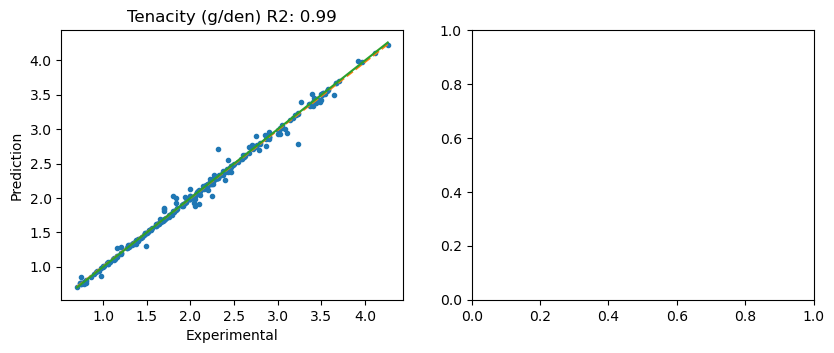

In [17]:
fig = plt.figure(figsize=(15,3.5))
for i in range(3):
    plt.subplot(1,3,i+1)
    experimental = outputs.iloc[:,i].values


    plt.plot(experimental,predicted[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    # reg
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')


    plt.plot(xspan,xspan,'-')
# reg
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1)),2)}")
    plt.xlabel("Experimental")
    plt.ylabel("Prediction")


in_norm_test = (inputs_test - in_mu) / in_std
in_norm_test = torch.tensor(in_norm_test.values, dtype=torch.float32)

predicted_test = net(in_norm_test).detach().numpy()

predicted_test = predicted_test * out_std.values + out_mu.values
plt.suptitle("Train Database")

# plot
fig = plt.figure(figsize=(15,3.5))

for i in range(3):
    plt.subplot(1,3,i+1)
    experimental = outputs_test.iloc[:,i].values
    plt.plot(experimental,predicted_test[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    plt.plot(xspan,xspan,'-')

    #plt.title(outputs.columns[i])

    plt.xlabel("Experimental")
    plt.ylabel("Prediction")

    plt.xlim([np.min(experimental),np.max(experimental)])
    plt.ylim([np.min(experimental),np.max(experimental)])
    

    # linear regression
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')
    # title reg 
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1)),2)}")

    

# text Test Database
plt.suptitle("Test Database")

# Test

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# Define tu modelo de red

# Función objetivo para Optuna
def objective(trial):
    # Sugerir valores para los hiperparámetros
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    
    net = Net(hidden_dim)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    batch_size = 128  # Tamaño de lote aleatorio
    num_samples = in_norm.size(0)

    for epoch in range(2000):

        # Selección aleatoria de índices
        indices = torch.randperm(num_samples)[:batch_size]
        in_batch = in_norm[indices]
        out_batch = out_norm[indices]

        optimizer.zero_grad()
        outputs_hat = net(in_batch)

        l1_weight = 0.0
        l2_weight = 1e-3

        # Regularización L2
        l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

        # Cálculo de la pérdida
        loss = criterion(outputs_hat, out_batch) + l2
        loss.backward()
        optimizer.step()

        # Mostrar la pérdida en cada 5000 épocas
        if epoch % 500 == 0:
            loss_print = round(loss.item(), 4)
            print(f'epoch {epoch}, loss {loss_print}')

        predicted_test = net(in_norm_test).detach().numpy()
        predicted_test = predicted_test * out_std.values + out_mu.values

        error = np.abs(predicted_test - outputs_test.values)
        error = error / outputs_test.values
        error = error.mean()

    return error



# Crear un estudio de Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Número de pruebas

# Mejores hiperparámetros encontrados
print("Best hyperparameters:", study.best_params)
best_params = study.best_params

[I 2024-10-30 16:00:19,601] A new study created in memory with name: no-name-8c38ee46-0646-4424-8858-7eaa4ccfa968
/tmp/ipykernel_89743/1775893013.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_89743/1775893013.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)


epoch 0, loss 0.9392
epoch 500, loss 0.0191
epoch 1000, loss 0.0161
epoch 1500, loss 0.0116


[I 2024-10-30 16:00:20,914] Trial 0 finished with value: 0.13895071947187976 and parameters: {'hidden_dim': 101, 'lr': 0.007478510748103629, 'weight_decay': 1.4273411165068818e-05}. Best is trial 0 with value: 0.13895071947187976.


epoch 0, loss 1.0221
epoch 500, loss 0.1171
epoch 1000, loss 0.0779
epoch 1500, loss 0.0467


[I 2024-10-30 16:00:22,131] Trial 1 finished with value: 0.1440942205984347 and parameters: {'hidden_dim': 16, 'lr': 0.0004086302651306236, 'weight_decay': 0.00018825006011232982}. Best is trial 0 with value: 0.13895071947187976.


epoch 0, loss 1.011
epoch 500, loss 0.0253
epoch 1000, loss 0.0135
epoch 1500, loss 0.0136


[I 2024-10-30 16:00:23,440] Trial 2 finished with value: 0.14870318083614173 and parameters: {'hidden_dim': 106, 'lr': 0.0026862650973734905, 'weight_decay': 2.2422350053790252e-05}. Best is trial 0 with value: 0.13895071947187976.


epoch 0, loss 0.9888
epoch 500, loss 0.076
epoch 1000, loss 0.059
epoch 1500, loss 0.0621


[I 2024-10-30 16:00:24,703] Trial 3 finished with value: 0.13651076792895636 and parameters: {'hidden_dim': 71, 'lr': 0.06362334055585608, 'weight_decay': 8.022166521448406e-05}. Best is trial 3 with value: 0.13651076792895636.


epoch 0, loss 1.0458
epoch 500, loss 0.2788
epoch 1000, loss 0.1374
epoch 1500, loss 0.0887


[I 2024-10-30 16:00:25,996] Trial 4 finished with value: 0.14827923858368602 and parameters: {'hidden_dim': 99, 'lr': 0.00011462708520940297, 'weight_decay': 0.00032788912028984096}. Best is trial 3 with value: 0.13651076792895636.


epoch 0, loss 1.016
epoch 500, loss 0.0357
epoch 1000, loss 0.028
epoch 1500, loss 0.0295


[I 2024-10-30 16:00:27,305] Trial 5 finished with value: 0.1362088961491848 and parameters: {'hidden_dim': 124, 'lr': 0.01909811365249094, 'weight_decay': 0.0006050303632013731}. Best is trial 5 with value: 0.1362088961491848.


epoch 0, loss 1.1064
epoch 500, loss 0.9957
epoch 1000, loss 0.7137
epoch 1500, loss 0.6184


[I 2024-10-30 16:00:28,525] Trial 6 finished with value: 0.2735573574543853 and parameters: {'hidden_dim': 24, 'lr': 3.341157533223576e-05, 'weight_decay': 1.846928456600009e-05}. Best is trial 5 with value: 0.1362088961491848.


epoch 0, loss 1.0716
epoch 500, loss 1.0289
epoch 1000, loss 0.923
epoch 1500, loss 0.7988


[I 2024-10-30 16:00:29,770] Trial 7 finished with value: 0.44728438662726433 and parameters: {'hidden_dim': 20, 'lr': 1.866040487607245e-05, 'weight_decay': 0.0007343994393535066}. Best is trial 5 with value: 0.1362088961491848.


epoch 0, loss 1.0347
epoch 500, loss 0.8697
epoch 1000, loss 0.7635
epoch 1500, loss 0.6797


[I 2024-10-30 16:00:31,108] Trial 8 finished with value: 0.32320459168980925 and parameters: {'hidden_dim': 65, 'lr': 1.8421011821878585e-05, 'weight_decay': 0.00012504571284082012}. Best is trial 5 with value: 0.1362088961491848.


epoch 0, loss 1.017
epoch 500, loss 0.0696
epoch 1000, loss 0.0506
epoch 1500, loss 0.031


[I 2024-10-30 16:00:32,506] Trial 9 finished with value: 0.13041798615506286 and parameters: {'hidden_dim': 125, 'lr': 0.00040101809911325997, 'weight_decay': 0.0001571195855374014}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.0082
epoch 500, loss 0.0732
epoch 1000, loss 0.04
epoch 1500, loss 0.0279


[I 2024-10-30 16:00:33,837] Trial 10 finished with value: 0.13525719969672395 and parameters: {'hidden_dim': 49, 'lr': 0.0006563547382457045, 'weight_decay': 5.503492935007434e-05}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.0583
epoch 500, loss 0.0705
epoch 1000, loss 0.0357
epoch 1500, loss 0.0267


[I 2024-10-30 16:00:35,113] Trial 11 finished with value: 0.14322820736919892 and parameters: {'hidden_dim': 48, 'lr': 0.000575142492366602, 'weight_decay': 5.82152379850512e-05}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.0951
epoch 500, loss 0.0445
epoch 1000, loss 0.0276
epoch 1500, loss 0.0209


[I 2024-10-30 16:00:36,391] Trial 12 finished with value: 0.1317637602469825 and parameters: {'hidden_dim': 49, 'lr': 0.0013698005933488195, 'weight_decay': 4.5345403319286206e-05}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.1815
epoch 500, loss 0.0307
epoch 1000, loss 0.0209
epoch 1500, loss 0.0173


[I 2024-10-30 16:00:37,714] Trial 13 finished with value: 0.1471840408671345 and parameters: {'hidden_dim': 44, 'lr': 0.0017874203419471146, 'weight_decay': 3.722532313210073e-05}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.0696
epoch 500, loss 0.1733
epoch 1000, loss 0.1175
epoch 1500, loss 0.065


[I 2024-10-30 16:00:39,097] Trial 14 finished with value: 0.14028848767910296 and parameters: {'hidden_dim': 84, 'lr': 0.0001554179162294908, 'weight_decay': 0.00016148624747831236}. Best is trial 9 with value: 0.13041798615506286.


epoch 0, loss 1.1081
epoch 500, loss 0.0255
epoch 1000, loss 0.0127
epoch 1500, loss 0.0104


[I 2024-10-30 16:00:40,516] Trial 15 finished with value: 0.12890152012381764 and parameters: {'hidden_dim': 123, 'lr': 0.002457157239236422, 'weight_decay': 3.7000660871173546e-05}. Best is trial 15 with value: 0.12890152012381764.


epoch 0, loss 0.9868
epoch 500, loss 0.0229
epoch 1000, loss 0.0118
epoch 1500, loss 0.0114


[I 2024-10-30 16:00:41,921] Trial 16 finished with value: 0.12084065906851243 and parameters: {'hidden_dim': 128, 'lr': 0.0035014517347238053, 'weight_decay': 1.129548929082321e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9851
epoch 500, loss 0.0184
epoch 1000, loss 0.0156
epoch 1500, loss 0.01


[I 2024-10-30 16:00:43,286] Trial 17 finished with value: 0.13561821610672808 and parameters: {'hidden_dim': 116, 'lr': 0.0039000943737819557, 'weight_decay': 1.1355265976407733e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0893
epoch 500, loss 0.0211
epoch 1000, loss 0.0148
epoch 1500, loss 0.0126


[I 2024-10-30 16:00:44,686] Trial 18 finished with value: 0.13025116364648676 and parameters: {'hidden_dim': 89, 'lr': 0.008249907243418281, 'weight_decay': 2.74570276766418e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0147
epoch 500, loss 0.028
epoch 1000, loss 0.0163
epoch 1500, loss 0.0183


[I 2024-10-30 16:00:46,080] Trial 19 finished with value: 0.12937017758851493 and parameters: {'hidden_dim': 112, 'lr': 0.017177665659201733, 'weight_decay': 1.1041158129375404e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9308
epoch 500, loss 0.0385
epoch 1000, loss 0.018
epoch 1500, loss 0.0154


[I 2024-10-30 16:00:47,487] Trial 20 finished with value: 0.14088018419359222 and parameters: {'hidden_dim': 125, 'lr': 0.0012938741356075872, 'weight_decay': 2.8333421193564423e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9726
epoch 500, loss 0.0295
epoch 1000, loss 0.0194
epoch 1500, loss 0.0199


[I 2024-10-30 16:00:48,857] Trial 21 finished with value: 0.13439240014194698 and parameters: {'hidden_dim': 111, 'lr': 0.022187683602012, 'weight_decay': 1.4204331831530525e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0527
epoch 500, loss 0.0204
epoch 1000, loss 0.0155
epoch 1500, loss 0.0147


[I 2024-10-30 16:00:50,270] Trial 22 finished with value: 0.1363317018220158 and parameters: {'hidden_dim': 116, 'lr': 0.00523338603929562, 'weight_decay': 1.0445737315761387e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9937
epoch 500, loss 0.0276
epoch 1000, loss 0.015
epoch 1500, loss 0.0101


[I 2024-10-30 16:00:51,664] Trial 23 finished with value: 0.13466828811150755 and parameters: {'hidden_dim': 91, 'lr': 0.0028453935109414687, 'weight_decay': 1.7238222540656252e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0438
epoch 500, loss 0.0206
epoch 1000, loss 0.0152
epoch 1500, loss 0.0152


[I 2024-10-30 16:00:53,010] Trial 24 finished with value: 0.13491462161715012 and parameters: {'hidden_dim': 127, 'lr': 0.01179183730031512, 'weight_decay': 1.0871728577978398e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0094
epoch 500, loss 0.0868
epoch 1000, loss 0.1041
epoch 1500, loss 0.091


[I 2024-10-30 16:00:54,344] Trial 25 finished with value: 0.15526202008658396 and parameters: {'hidden_dim': 115, 'lr': 0.08812890451124741, 'weight_decay': 2.2480531509327397e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0353
epoch 500, loss 0.0465
epoch 1000, loss 0.0347
epoch 1500, loss 0.0265


[I 2024-10-30 16:00:55,672] Trial 26 finished with value: 0.13647571695197921 and parameters: {'hidden_dim': 98, 'lr': 0.0308445644624644, 'weight_decay': 3.4670363839187774e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9574
epoch 500, loss 0.0213
epoch 1000, loss 0.0203
epoch 1500, loss 0.0224


[I 2024-10-30 16:00:56,964] Trial 27 finished with value: 0.12540393467361097 and parameters: {'hidden_dim': 81, 'lr': 0.013349147746249936, 'weight_decay': 1.7518687295466583e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0603
epoch 500, loss 0.0162
epoch 1000, loss 0.0175
epoch 1500, loss 0.016


[I 2024-10-30 16:00:58,267] Trial 28 finished with value: 0.1375339578655884 and parameters: {'hidden_dim': 79, 'lr': 0.004579582348651629, 'weight_decay': 1.931424049314954e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0534
epoch 500, loss 0.0185
epoch 1000, loss 0.0147
epoch 1500, loss 0.0129


[I 2024-10-30 16:00:59,568] Trial 29 finished with value: 0.12917247539724827 and parameters: {'hidden_dim': 61, 'lr': 0.009459879893986854, 'weight_decay': 1.6028743600651784e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9413
epoch 500, loss 0.0258
epoch 1000, loss 0.0174
epoch 1500, loss 0.0135


[I 2024-10-30 16:01:00,831] Trial 30 finished with value: 0.13477466105537178 and parameters: {'hidden_dim': 33, 'lr': 0.005438021273564767, 'weight_decay': 2.7487930590498665e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0285
epoch 500, loss 0.0269
epoch 1000, loss 0.0178
epoch 1500, loss 0.0193


[I 2024-10-30 16:01:02,095] Trial 31 finished with value: 0.141181279103104 and parameters: {'hidden_dim': 59, 'lr': 0.009133161097674713, 'weight_decay': 1.4168624337437144e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.1106
epoch 500, loss 0.0234
epoch 1000, loss 0.0172
epoch 1500, loss 0.0148


[I 2024-10-30 16:01:03,393] Trial 32 finished with value: 0.12599688851077348 and parameters: {'hidden_dim': 76, 'lr': 0.011779633278125194, 'weight_decay': 1.5354795362026358e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9843
epoch 500, loss 0.0273
epoch 1000, loss 0.0153
epoch 1500, loss 0.0124


[I 2024-10-30 16:01:04,677] Trial 33 finished with value: 0.1368478124836959 and parameters: {'hidden_dim': 76, 'lr': 0.0026925362225020378, 'weight_decay': 2.3110306530052057e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.1231
epoch 500, loss 0.0375
epoch 1000, loss 0.0374
epoch 1500, loss 0.034


[I 2024-10-30 16:01:06,013] Trial 34 finished with value: 0.13631391944236704 and parameters: {'hidden_dim': 106, 'lr': 0.034363983171699225, 'weight_decay': 1.494840800348889e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0543
epoch 500, loss 0.0274
epoch 1000, loss 0.0293
epoch 1500, loss 0.0196


[I 2024-10-30 16:01:07,391] Trial 35 finished with value: 0.1314209663892686 and parameters: {'hidden_dim': 93, 'lr': 0.012908396234266298, 'weight_decay': 2.0590022998831363e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0447
epoch 500, loss 0.0264
epoch 1000, loss 0.0167
epoch 1500, loss 0.0111


[I 2024-10-30 16:01:08,748] Trial 36 finished with value: 0.14013119726936593 and parameters: {'hidden_dim': 70, 'lr': 0.00673852788626573, 'weight_decay': 1.3772670377661209e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9939
epoch 500, loss 0.0216
epoch 1000, loss 0.0192
epoch 1500, loss 0.0101


[I 2024-10-30 16:01:10,077] Trial 37 finished with value: 0.12320432349133417 and parameters: {'hidden_dim': 83, 'lr': 0.0023842704735219915, 'weight_decay': 3.361485618264347e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.99
epoch 500, loss 0.047
epoch 1000, loss 0.0516
epoch 1500, loss 0.0433


[I 2024-10-30 16:01:11,455] Trial 38 finished with value: 0.139809740127442 and parameters: {'hidden_dim': 81, 'lr': 0.04810652007829535, 'weight_decay': 8.064439298170544e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0516
epoch 500, loss 0.0199
epoch 1000, loss 0.0251
epoch 1500, loss 0.0133


[I 2024-10-30 16:01:12,817] Trial 39 finished with value: 0.1305633173280725 and parameters: {'hidden_dim': 71, 'lr': 0.01540170144279759, 'weight_decay': 1.81255522804966e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0792
epoch 500, loss 0.0239
epoch 1000, loss 0.013
epoch 1500, loss 0.0129


[I 2024-10-30 16:01:14,191] Trial 40 finished with value: 0.1446490309474845 and parameters: {'hidden_dim': 86, 'lr': 0.0033407576799286335, 'weight_decay': 1.2824767513802093e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0589
epoch 500, loss 0.018
epoch 1000, loss 0.011
epoch 1500, loss 0.0118


[I 2024-10-30 16:01:15,566] Trial 41 finished with value: 0.13534210856372197 and parameters: {'hidden_dim': 96, 'lr': 0.005781327604883412, 'weight_decay': 2.2449239595264867e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.934
epoch 500, loss 0.0244
epoch 1000, loss 0.0162
epoch 1500, loss 0.0109


[I 2024-10-30 16:01:16,890] Trial 42 finished with value: 0.12940348249093464 and parameters: {'hidden_dim': 107, 'lr': 0.002363943874398706, 'weight_decay': 3.765470518461912e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0568
epoch 500, loss 0.033
epoch 1000, loss 0.0206
epoch 1500, loss 0.0149


[I 2024-10-30 16:01:18,285] Trial 43 finished with value: 0.13800245496034733 and parameters: {'hidden_dim': 102, 'lr': 0.0017398046876548076, 'weight_decay': 1.733263272827072e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 0.9302
epoch 500, loss 0.0388
epoch 1000, loss 0.0333
epoch 1500, loss 0.0223


[I 2024-10-30 16:01:19,563] Trial 44 finished with value: 0.1341067006329882 and parameters: {'hidden_dim': 65, 'lr': 0.0009806334093015266, 'weight_decay': 2.5548081013667004e-05}. Best is trial 16 with value: 0.12084065906851243.


epoch 0, loss 1.0474
epoch 500, loss 0.0206
epoch 1000, loss 0.0146
epoch 1500, loss 0.0141


[I 2024-10-30 16:01:20,904] Trial 45 finished with value: 0.12035621148637722 and parameters: {'hidden_dim': 58, 'lr': 0.007366327649424258, 'weight_decay': 3.175083609310085e-05}. Best is trial 45 with value: 0.12035621148637722.


epoch 0, loss 1.1327
epoch 500, loss 0.02
epoch 1000, loss 0.0167
epoch 1500, loss 0.0142


[I 2024-10-30 16:01:22,202] Trial 46 finished with value: 0.139432574653137 and parameters: {'hidden_dim': 54, 'lr': 0.0083114566349644, 'weight_decay': 3.06381069355276e-05}. Best is trial 45 with value: 0.12035621148637722.


epoch 0, loss 0.9549
epoch 500, loss 0.0272
epoch 1000, loss 0.0295
epoch 1500, loss 0.0272


[I 2024-10-30 16:01:23,563] Trial 47 finished with value: 0.14997930837473938 and parameters: {'hidden_dim': 76, 'lr': 0.024285542801362393, 'weight_decay': 4.909364003520919e-05}. Best is trial 45 with value: 0.12035621148637722.


epoch 0, loss 1.0674
epoch 500, loss 0.0301
epoch 1000, loss 0.02
epoch 1500, loss 0.022


[I 2024-10-30 16:01:24,996] Trial 48 finished with value: 0.13756759471982039 and parameters: {'hidden_dim': 35, 'lr': 0.012712813894839005, 'weight_decay': 1.9994672739027593e-05}. Best is trial 45 with value: 0.12035621148637722.


epoch 0, loss 1.0569
epoch 500, loss 0.0199
epoch 1000, loss 0.0117
epoch 1500, loss 0.0105


[I 2024-10-30 16:01:26,326] Trial 49 finished with value: 0.12600180577774742 and parameters: {'hidden_dim': 67, 'lr': 0.004157688800668215, 'weight_decay': 1.0345967037031532e-05}. Best is trial 45 with value: 0.12035621148637722.


Best hyperparameters: {'hidden_dim': 58, 'lr': 0.007366327649424258, 'weight_decay': 3.175083609310085e-05}


In [ ]:
import torch

# Crear y entrenar el modelo con los mejores hiperparámetros
hidden_dim = best_params['hidden_dim']
lr = best_params['lr']
weight_decay = best_params['weight_decay']

model = Net(hidden_dim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

batch_size = 128  # Tamaño de lote aleatorio
num_samples = in_norm.size(0)

for epoch in range(20000):

    # Selección aleatoria de índices
    indices = torch.randperm(num_samples)[:batch_size]
    in_batch = in_norm[indices]
    out_batch = out_norm[indices]

    optimizer.zero_grad()
    outputs_hat = net(in_batch)

    l1_weight = 0.0
    l2_weight = 1e-3

    # Regularización L2
    l2 = l2_weight * net.compute_l2_loss(net.fc1.weight)

    # Cálculo de la pérdida
    loss = criterion(outputs_hat, out_batch) + l2
    loss.backward()
    optimizer.step()

    # Mostrar la pérdida en cada 5000 épocas
    if epoch % 5000 == 0:
        loss_print = round(loss.item(), 4)
        print(f'epoch {epoch}, loss {loss_print}')

predicted = net(in_norm).detach().numpy()
predicted = predicted * out_std.values + out_mu.values


epoch 0, loss 0.0055
epoch 5000, loss 0.011
epoch 10000, loss 0.0095
epoch 15000, loss 0.0101


Text(0.5, 0.98, 'Test Database')

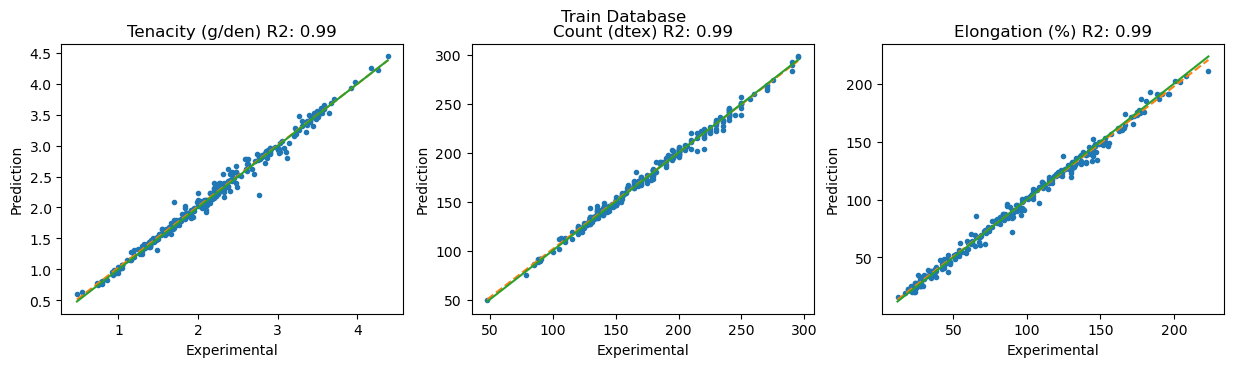

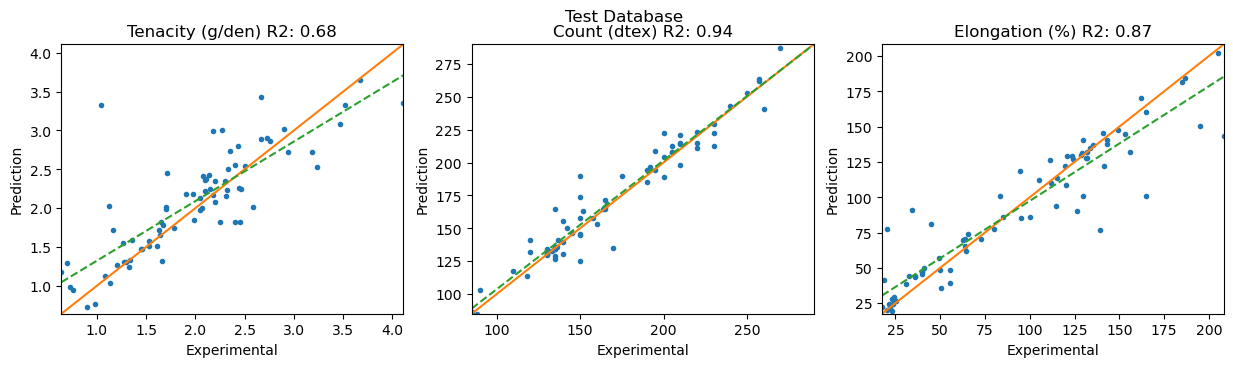

In [ ]:
fig = plt.figure(figsize=(15,3.5))
for i in range(3):
    plt.subplot(1,3,i+1)
    experimental = outputs.iloc[:,i].values


    plt.plot(experimental,predicted[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    # reg
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')


    plt.plot(xspan,xspan,'-')
# reg
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted[:,i].reshape(-1,1)),2)}")
    plt.xlabel("Experimental")
    plt.ylabel("Prediction")


in_norm_test = (inputs_test - in_mu) / in_std
in_norm_test = torch.tensor(in_norm_test.values, dtype=torch.float32)

predicted_test = net(in_norm_test).detach().numpy()

predicted_test = predicted_test * out_std.values + out_mu.values
plt.suptitle("Train Database")

# plot
fig = plt.figure(figsize=(15,3.5))

for i in range(3):
    plt.subplot(1,3,i+1)
    experimental = outputs_test.iloc[:,i].values
    plt.plot(experimental,predicted_test[:,i],'.')

    xspan = np.linspace(np.min(experimental),np.max(experimental),100)

    plt.plot(xspan,xspan,'-')

    #plt.title(outputs.columns[i])

    plt.xlabel("Experimental")
    plt.ylabel("Prediction")

    plt.xlim([np.min(experimental),np.max(experimental)])
    plt.ylim([np.min(experimental),np.max(experimental)])
    

    # linear regression
    reg = LinearRegression().fit(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1))

    plt.plot(xspan, reg.predict(xspan.reshape(-1,1)), '--')
    # title reg 
    plt.title(f"{outputs.columns[i]} R2: {round(reg.score(experimental.reshape(-1,1), predicted_test[:,i].reshape(-1,1)),2)}")

    

# text Test Database
plt.suptitle("Test Database")